In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import numpy as np
import  matplotlib.pyplot   as plt
import math
import logging
# from pytorch3d.loss import chamfer_distance
import csv
import time
import argparse
from datetime import datetime
from torcheval.metrics.functional import multiclass_confusion_matrix
import json
# from torchsummary import summary

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

# Getting the user and setting the path and gpu correctly
userPath = os.getcwd().split('/')[2]
cuda_own = "cuda:0"
if userPath == "newfasant2":
    userPath = userPath + "/N101"
    cuda_own = "cuda:1"

device = (
    cuda_own
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

class args():
    def __init__(self, input_path, data_type, use_case):
        self.input_path = input_path
        self.data_type = data_type
        self.use_case = use_case

args = args("/home/newfasant/N101-IA/Datasets/Reorganized/Classification_12500_0_64_f_64_d_POV_50.0_SNR_10.0", "ISAR", "Classification")

seed= 152

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

print(f"\nUsing {device} device, {args.data_type} data type, {args.use_case} use case and seed {seed}.\n")
logging.info(f"\nUsing {device} device, {args.data_type} data type, {args.use_case} use case and seed {seed}.\n")



Using cuda:0 device, ISAR data type, Classification use case and seed 152.



In [53]:
class CustomDataset(Dataset):
    """Custom dataset for loading data files and their corresponding labels.

    Initializes the CustomDataset instance.

    Args:
        npy_dir (str): Directory containing the data files.
        labels_file (str): File path to the file containing labels.
        transform_ISAR (callable, optional): Optional transform to be applied on a sample for ISAR data type.
        transform_npy (callable, optional): Optional transform to be applied on a sample for npy data type.
    """

    def __init__(self, dir, transform_ISAR=None, transform_npy=None):

        self.dir = dir

        if args.data_type == 'npy':
            # List all .npy files in the directory.
            self.file_names = [f for f in os.listdir(dir) if f.endswith('.npy') and f.startswith('sample_') and not f.endswith('fft.npy') and not f.endswith('perfil.npy') and not f.endswith('field.npy') and not f.endswith('field_amp.npy') and not f.endswith('field_ph.npy')]
            self.transform = transform_npy
        elif args.data_type == 'fft':
            # List all fft files in the directory.
            self.file_names = [f for f in os.listdir(dir) if f.endswith('fft.npy')]
            self.transform = transform_npy
        elif args.data_type == 'fft_perfil':
            # List all fft (in profiles) files in the directory.
            self.file_names = [f for f in os.listdir(dir) if f.endswith('perfil.npy')]
            self.transform = transform_npy
        elif args.data_type == 'field':
            # List all field files in the directory.
            self.file_names = [f for f in os.listdir(dir) if f.endswith('field.npy')]
            self.transform = transform_npy
        elif args.data_type == 'field_amp_npy':
            # List all files containing the amplitude of the field in the directory.
            self.file_names = [f for f in os.listdir(dir) if f.endswith('field_amp.npy')]
            self.transform = transform_npy
        elif args.data_type == 'field_ph_npy':
            # List all files containing the complex phase of the field in the directory.
            self.file_names = [f for f in os.listdir(dir) if f.endswith('field_ph.npy')]
            self.transform = transform_npy
        elif args.data_type == 'perfil_png':
            # List all the images plotting the fft (in profiles) in the directory.
            self.file_names = [f for f in os.listdir(dir) if f.endswith('perfil.png')]
            self.transform = transform_ISAR
        elif args.data_type == 'field_amp_png':
            # List all the images plotting the amplitude of the field in the directory.
            self.file_names = [f for f in os.listdir(dir) if f.endswith('amp.png')]
            self.transform = transform_ISAR
        elif args.data_type == 'field_ph_png':
            # List all the images plotting the complex phase of the field in the directory.
            self.file_names = [f for f in os.listdir(dir) if f.endswith('ph.png')]
            self.transform = transform_ISAR
        elif args.data_type == 'ISAR':
            # List all the ISAR images in the directory.
            self.file_names = [f for f in os.listdir(dir) if f.endswith('.png') and not f.endswith('perfil.png') and not f.endswith('amp.png') and not f.endswith('ph.png')]
            self.transform = transform_ISAR
            
        if args.use_case == "Classification":
            # The network must say which of the geometries corresponds to a particular input
            _, _, result = dir.split('/')[-1].partition('_')  # Divides in 3 parts: before, splitter and after
            result = f"_{result}"
            # Load labels vector from the labels file.
            self.labels_vector = np.load(dir + '/labels_vector' + result + '.npy')
        elif args.use_case == "Regression":
            # The network must output the coordinates of the object of a particular input
            self.coords = np.load(dir + "/coords.npy")[:, 1:]
            self.dist_max = self.dist_max_calc()
            
        # Sort files based on the sample id which is the number right after "sample_". For example, "sample_5.npy" will be split into ['sample', '5', '.npy'].
        self.file_names.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
            
    def __len__(self):
        """Returns the total number of samples in the dataset.

        Returns:
            int: Number of samples.
        """
        return len(self.file_names)
    
    def __getitem__(self, idx):

        # Construct the full file path for the sample.
        file_path = os.path.join(self.dir, self.file_names[idx])
        
        if args.data_type == 'npy' or args.data_type == 'fft' or args.data_type == 'fft_perfil' or args.data_type == 'field' or args.data_type == 'field_amp_npy' or args.data_type == 'field_ph_npy':
            # Load the numpy array with shape (2 x n x m).
            data = np.load(file_path)
            data = np.transpose(data, (2, 0, 1))
            
            # Convert the numpy array to a PyTorch tensor.
            data = torch.tensor(data, dtype=torch.float32).to(device)
        elif args.data_type == 'ISAR' or args.data_type == 'perfil_png' or args.data_type == 'field_amp_png' or args.data_type == 'field_ph_png':
            # Load the image and convert it to "L"
            data = Image.open(file_path).convert("L")
            
            # If a transform is set, apply it
            if self.transform:
                data = self.transform(data).to(device)
            else:
                data.to(device)

        if args.use_case == "Classification":
            # Load labels vector from the labels file.
            target = torch.tensor(self.labels_vector[idx], dtype=torch.float32).to(device)
        elif args.use_case == "Regression":
            # Load coordinates from the coords matrix file.
            target = torch.tensor(self.coords[idx,:], dtype=torch.float32).to(device)
        
        return data, target
    
    def dist_max_calc(self):
        # Returns maximux size of the coordinates vector of the points
        sample_coords = self.coords[1].reshape(int(self.coords.shape[1]/3),3)
        dist_max = 0.0
        for i in range(len(sample_coords)):
            if sum(sample_coords[i] ** 2) > dist_max:
                dist_max = sum(sample_coords[i] ** 2)
            dist_max = np.sqrt(dist_max)
        return dist_max

class CNNModule(nn.Module):
    """Convolutional module to extract features from a 2-channel input.

    This network processes an input tensor with shape (batch_size, 2, height, width)
    and returns a flattened feature vector.
    """

    def __init__(self):
        super(CNNModule, self).__init__()
        
        # Setting the neural networks layers
        # Convolution
        self.conv1 = nn.LazyConv2d(out_channels=96, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.LazyConv2d(256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.LazyConv2d(384, kernel_size=3, padding=1)
        self.conv4 = nn.LazyConv2d(384, kernel_size=3, padding=1)
        self.conv5 = nn.LazyConv2d(256, kernel_size=3, padding=1)
        # Pooling
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        # ReLu and flattening
        self.ReLU = nn.ReLU()
        self.Flatten = nn.Flatten()

    def forward(self, x):
        # Applying the layers in the correct order
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.ReLU(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.ReLU(x)
        x = self.conv4(x)
        x = self.ReLU(x)
        x = self.conv5(x)
        x = self.ReLU(x)
        x = self.pool3(x)

        x = self.gap(x)

        x = self.Flatten(x)
        return x
    
class GeometryPredictor(nn.Module):

    def __init__(self, num_labels=None, coords_width=None):

        super(GeometryPredictor, self).__init__()
        
        self.cnn = CNNModule()

        # --- MODIFIED FULLY CONNECTED LAYERS ---
        # The input is now 256 (from the GAP layer), not a huge flattened vector
        
        # We can define the layers directly without 'Lazy'
        self.fc1 = nn.Linear(256, 512) # 256 in, 512 out
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(512, 512) # 512 in, 512 out
        self.relu2 = nn.ReLU()

        # Define fc3 based on the use case
        if args.use_case == "Classification":
            self.fc3 = nn.Linear(512, num_labels)  # 512 in, num_labels out
        if args.use_case == "Regression":
            self.fc3 = nn.Linear(512, coords_width) # 512 in, coords_width out

    def forward(self, x):

        # Process the input through the CNN to extract features.
        # This now outputs a tensor of shape (batch_size, 256)
        features = self.cnn(x)

        # Pass the features through fully connected layers.
        x = self.fc1(features)
        x = self.relu1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)

        # Return the final results of the last layer of the network
        output = self.fc3(x)

        return output

transform_I = transforms.Compose([
    transforms.Resize((128, 128)),   # Change this depending of image sizes
    transforms.ToTensor()            # Converting images to tensors
])

dataset = CustomDataset(dir = args.input_path, transform_ISAR=transform_I)

if args.use_case == "Classification":
    # Initialize the model
    model = GeometryPredictor(num_labels=len(np.unique(dataset.labels_vector))).to(device)

    # Setting the optimizer and the loss function
    optimizer = optim.SGD(params=model.parameters(), lr=0.01)
    criterion_CEL = nn.CrossEntropyLoss()
    
elif args.use_case == "Regression":
    # Intitialize the model
    model = GeometryPredictor(coords_width=dataset.coords.shape[1], num_labels=len(np.unique(dataset.labels_vector))).to(device)

    # Setting the optimizer and the loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001)


In [54]:
# Split the dataset into train, validation and test
train_size = int(0.5 * len(dataset))
val_size = int(0.25 * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(seed)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

# Crear DataLoaders para iterar sobre los datasets
train_batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [57]:
# Cargar un modelo
model.load_state_dict(torch.load("/home/newfasant/N101-IA/CNN/Models/Classification_ISAR_SSRJTDNTNFGEKMBGHLLMMNSSY_POV_50.0_SNR_10.0_12500_0samples_71ep_32bs.pth"))
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')
print(torch.cuda.get_device_properties(0))

Total number of parameters: 3727065
_CudaDeviceProperties(name='NVIDIA RTX 6000 Ada Generation', major=8, minor=9, total_memory=48647MB, multi_processor_count=142, uuid=936b28b6-1e2c-1996-649d-19c45902cbf2, L2_cache_size=96MB)


/tmp/ipykernel_1932118/1535526544.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/newfasant/N101-IA/CNN/Models/Classification_ISA

In [58]:
# Caja empleada para cronometrar la inferencia.

model.eval()
# model.to(device)

start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)

start_event.record()
with torch.inference_mode():
    for data, target_label in test_loader:
        output_logits = model(data)
end_event.record()

torch.cuda.synchronize()

elapsed_time_ms = start_event.elapsed_time(end_event)
avg_time_ms = elapsed_time_ms / len(test_dataset)

print(f"Average inference time: {avg_time_ms:.10f} ms")
print(f"Test dataset length: {len(test_dataset)}")

torch.cuda.empty_cache()

Average inference time: 0.5778941406 ms
Test dataset length: 3125


Test Accuracy: 96.70%
Tiempo por sample: 0.0000778368 seconds
Error medio de test:  0.09774383902549744
Fin de la ejecución


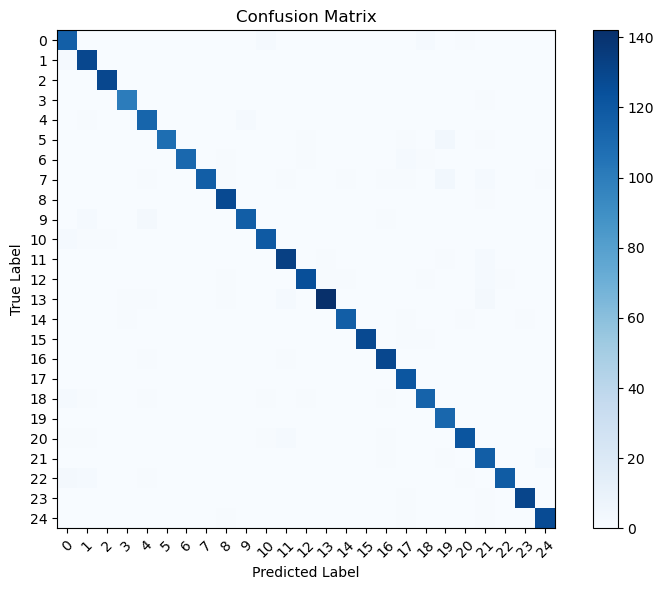

In [32]:
# Caja empleada para evaluar la precisión del modelo.

torch.cuda.empty_cache()

model.eval()
model.to(device)

# Test evaluation
if device == 'cuda':
    torch.cuda.synchronize()

with torch.no_grad():
    if args.use_case == "Classification":
        for data, target_label in test_loader:
            
            aver=time.time()
            output_logits = model(data)
            aver2=time.time()

            pred_probs = F.softmax(output_logits, dim=1)
            correct_predictions = (pred_probs.argmax(dim=1) == target_label).sum().item()
            # print(f"length pred_probs: {len(pred_probs)}, length correct_predictions: {correct_predictions}, has to be equal to {pred_probs.argmax(dim=1) == target_label}")
            accuracy = correct_predictions / len(target_label) * 100
            print(f"Test Accuracy: {accuracy:.2f}%")

            # Compute confusion matrix
            cm = multiclass_confusion_matrix(pred_probs.argmax(dim=1), target_label.long(), num_classes=len(np.unique(dataset.labels_vector)))
            cm = cm.cpu().numpy()
            # Save confusion matrix as a heatmap
            plt.figure(figsize=(8, 6))
            plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title('Confusion Matrix')
            plt.colorbar()
            plt.xticks(np.arange(len(np.unique(dataset.labels_vector))), np.unique(dataset.labels_vector), rotation=45)
            plt.yticks(np.arange(len(np.unique(dataset.labels_vector))), np.unique(dataset.labels_vector))
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.tight_layout()
            test_loss = criterion_CEL(output_logits, target_label.long())

    elif args.use_case == "Regression":
        for data, target_coords in test_loader:
            
            outputs = model(data)

            outputs = outputs.view(-1, int(dataset.coords.shape[1]/3), 3)  
            target_coords = target_coords.view(-1, int(dataset.coords.shape[1]/3), 3)
            lossChamfer, _ = chamfer_distance(outputs, target_coords)
            
            test_loss = lossChamfer.item()

print(f"Tiempo por sample: {(aver2-aver)/len(test_dataset):.10f} seconds")

print("Error medio de test: ", test_loss.item())

print("Fin de la ejecución")

torch.cuda.empty_cache()